In [3]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections
import numpy as np
import rdflib
import pandas as pd
import xml.etree.ElementTree as et
from itertools import compress
import glob
import seaborn as sns
from sklearn.metrics import roc_auc_score
import sklearn

In [186]:

def get_instance_set(root):
    instances_set = set()
    for child in root:
        sub = str(child.attrib.values())[14:-3]
        if '/resource/' in sub and '/Category' not in sub:
            instances_set.add(sub)
            
    return instances_set


def get_label_to_instance(instances_set):
    instance_label_set = set()
    label_to_instance = {}
    for each in instances_set:
        label = each.split('/')[-1]
        instance_label_set.add(label)
        label_to_instance[label] = each
        
    return instance_label_set, label_to_instance


'''
Load mapping file (Ground truth mapping data)
'''
def get_gt_mapping(filepath):
    root = mapping_file(filepath)
    mapping = {}
    for child in root:
        for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
            node1 = str(grand[0][0].attrib.values())[14:-3]
            node2 = str(grand[0][1].attrib.values())[14:-3]
            mapping[node2] = node1
    return mapping

In [19]:
file1 = 'data/xml/memory_alpha.xml'
tree1 = et.parse(file1)
root1 = tree1.getroot()

file2 = 'data/xml/memory_beta.xml'
tree2 = et.parse(file2)
root2 = tree2.getroot()

mapping_filedir = 'data/mappings/memory_alpha_vs_beta.xml'
mapping = get_gt_mapping(mapping_filedir)
root = mapping_file(mapping_filedir)


In [13]:
instances_set1 = get_instance_set(root1)
instances_set2 = get_instance_set(root2)
instance_label_set1, label_to_instance1 = get_label_to_instance(instances_set1)
instance_label_set2, label_to_instance2 = get_label_to_instance(instances_set2)

In [53]:
for x in instance_label_set1.intersection(instance_label_set2):
    if not mapping.get(label_to_instance2.get(x)):
        mapping[label_to_instance2.get(x)] = label_to_instance1.get(x)
    

In [57]:
def build_graph(root, nodelist):
    
    graph = nx.Graph()

    for child in root:
        sub = str(child.attrib.values())[14:-3]
        for grand_child in child:
            predicate = grand_child.tag
            obj = str(grand_child.attrib.values())[14:-3]
            if (sub in nodelist) and (obj in nodelist):
                graph.add_edge(sub, obj, predicate=predicate)
                
    return graph

In [58]:
graph1 = build_graph(root1, mapping.values())
graph2 = build_graph(root2, mapping.keys())


In [59]:
'''Returns list of unique relations stored as relation:index (dictionary) pair'''
def generate_relation_dict(graph):
    unique_relation_set = set()
    for a,b in graph.adjacency():
        for c,d in b.items():
            unique_relation_set.add(d['predicate'])
    relation_dict = {}
    for index, relation in enumerate(unique_relation_set):
        relation_dict[relation] = index

    return relation_dict

'''Returns list of unique nodes stored as node:index (dictionary) pair'''
def generate_node_dict(graph):
    instance_dict = {}
    for index, instance in enumerate(graph):
        instance_dict[instance] = index

    return  instance_dict

'''Returns an incidence matrix(n*m), where n is number of unique relations and m is number of 
unique nodes'''
def generate_incidence_matrix(graph, nodes_json, relations_json):
    
    incidence_matrix = np.zeros((len(relations_json), len(nodes_json)))
    for node_1, adj_to_node_1 in graph.adjacency():
        for node_2, adj_to_node_2 in adj_to_node_1.items():
            incidence_matrix[relations_json.get(adj_to_node_2['predicate']), nodes_json.get(node_1)] += 1
    
    incidence_matrix_df = pd.DataFrame(incidence_matrix, columns=list(nodes_json.keys()), index=list(relations_json.keys()))
            
    return incidence_matrix, incidence_matrix_df


In [60]:
nodes_json1 = generate_node_dict(graph1)
relations_json1 = generate_relation_dict(graph1)
incidence_matrix1, incidence_matrix_df1 = generate_incidence_matrix(graph1, nodes_json1, relations_json1)

nodes_json2 = generate_node_dict(graph2)
relations_json2 = generate_relation_dict(graph2)
incidence_matrix2, incidence_matrix_df2 = generate_incidence_matrix(graph2, nodes_json2, relations_json2)


In [153]:
'''
Input: Two List of nodes and mapping between the two list
Returns number of common nodes, combined nodes and a dictionary of common nodes (node:index)
'''

def generate_node_count(nodelist1, nodelist2, mapping):
    common_nodes = 0
    dict_common_nodes = {}
    for item in nodelist1:
        if mapping.get(item) in nodelist2:
            common_nodes += 1
            dict_common_nodes[item] = mapping.get(item)
    all_nodes = len(nodelist1)+len(nodelist2)+common_nodes
    return common_nodes, all_nodes, dict_common_nodes

def get_common_node_count(list1, list2):
    n = 0
    for item in list1:
        if mapping.get(item) in list2:
            n += 1
    return n

def get_common_node_dict(list1, list2):
    common_dict = {}
    for item in list1:
        if  mapping.get(item) in list2:
            common_dict[item] = mapping.get(item)
            
    return common_dict

def get_union_node_count(list1, list2):
    common_node_count = func_common_node_count(list1, list2)
    return len(list1)+len(list2)-common_node_count


#### Approach 1: Jaccard approach

In [189]:
common_node_dict = get_common_node_dict(graph2.nodes(), graph1.nodes())

g1_common_df = incidence_matrix_df1[common_node_dict.values()]
g2_common_df = incidence_matrix_df2[common_node_dict.keys()]

g1_common = np.array(g1_common_df)
g2_common = np.array(g2_common_df)

common_node_count = np.zeros((len(g1_common), len(g2_common)))
common_node_prob = np.zeros((len(g1_common), len(g2_common)))

i=0
for row_g1 in g1_common:
    j=0
    n1 = list(compress(list(g1_common_df.columns), row_g1))
    for row_g2 in g2_common:
        n2 = list(compress(list(g2_common_df.columns), row_g2))
        common_node_count[i, j] = get_common_node_count(n2, n1) # Gives the number of common node incident to the both relations.
        union = get_union_node_count(n1, n2)
        if len(n1)==0 or len(n2)==0:
            common_node_prob[i, j] = 0
        else:
            common_node_prob[i, j] = common_node_count[i, j]/union
        j+=1
    i+=1

    
common_node_count_df = pd.DataFrame(common_node_count, index=list(incidence_matrix_df1.index), \
                                    columns=list(incidence_matrix_df2.index))
common_node_prob_df = pd.DataFrame(common_node_prob, index=list(incidence_matrix_df1.index), \
                                    columns=list(incidence_matrix_df2.index))


#### Approach 1: Intersection over Product (IoP)

In [166]:
common_node_dict = get_common_node_dict(graph2.nodes(), graph1.nodes())

g1_common_df = incidence_matrix_df1[common_node_dict.values()]
g2_common_df = incidence_matrix_df2[common_node_dict.keys()]

g1_common = np.array(g1_common_df)
g2_common = np.array(g2_common_df)

common_node_count = np.zeros((len(g1_common), len(g2_common)))
common_node_prob = np.zeros((len(g1_common), len(g2_common)))

i=0
for row_g1 in g1_common:
    j=0
    n1 = list(compress(list(g1_common_df.columns), row_g1))
    for row_g2 in g2_common:
        n2 = list(compress(list(g2_common_df.columns), row_g2))
        common_node_count[i, j] = get_common_node_count(n2, n1) # Gives the number of common node incident to the both relations.
        if len(n1)==0 or len(n2)==0:
            common_node_prob[i, j] = 0
        else:
            common_node_prob[i, j] = common_node_count[i, j]**2/(len(n1)*len(n2))
        j+=1
    i+=1

    
common_node_count_df = pd.DataFrame(common_node_count, index=list(incidence_matrix_df1.index), \
                                    columns=list(incidence_matrix_df2.index))
common_node_prob_df = pd.DataFrame(common_node_prob, index=list(incidence_matrix_df1.index), \
                                    columns=list(incidence_matrix_df2.index))


In [181]:

def list_mod(string_list):
    temp_list = ['']*len(string_list)
    for i in range(len(string_list)):
        split = string_list[i].split('{')[1].split('}')
        temp_list[i] = str(split[0])+str(split[1])
    return temp_list

def string_mod(string):
    split = string_list[i].split('{')[1].split('}')
    return split[0]+split[1]

index = list_mod(list(common_node_count_df.index))
columns = list_mod(list(common_node_count_df.columns))

### Predict similarity between relations from two ontology.
Prediction heuristics: For relation r1 from ontology 1, it will find out relation r2 from ontology 2 by calculating number of incidences between r1 and r2. The combination which gives the greatest incidence score is selected as the m similar relation and listed in prediction table

In [169]:
r,c = common_node_count_df.shape
df_prediction_table_full = pd.DataFrame(columns=['graph1_relations', 'graph2_relations'])
for j in range(c):
    max_val = max(common_node_prob[:, j])
    i = common_node_prob[:, j].tolist().index(max_val)
    row = {'graph2_relations':columns[j].split('/')[-1], 'graph1_relations':index[i].split('/')[-1]}
    row_full = {'graph2_relations':split_column[0]+split_column[1], 'graph1_relations':split_index[0]+split_index[1]}
    df_prediction_table_full = df_prediction_table_full.append(row_full, ignore_index=True)


#### Truth table is calculated from the Ground Truth dataset

In [170]:
df_true_table_full = pd.DataFrame(columns=['graph1_relations', 'graph2_relations'])
dict_true_table_full = {}
for child in root:
    for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
        property1 = str(grand[0][0].attrib.values())[14:-3]
        property2 = str(grand[0][1].attrib.values())[14:-3]
        if 'property' in property1:
            row_full = {'graph1_relations':property1, 'graph2_relations':property2}
            df_true_table_full = df_true_table_full.append(row_full, ignore_index=True)
            dict_true_table_full[row_full['graph1_relations']] = row_full['graph2_relations']

#### Create final list of relations to build the confusion matrix
Rows of the confusion matrix: List of relations from Ontology 1 <br />
Columns of the confusion matrix: List of relations from Ontology 2 <br />
This final list is created by checking both r1 and r2 availability in Ground truth data

In [188]:
common_node_prob_df.index = index
common_node_prob_df.columns = columns

predict_true_common_2_full = set(df_prediction_table_full['graph2_relations']).intersection(set(df_true_table_full['graph2_relations']))
predict_true_common_1_full = set(df_prediction_table_full['graph1_relations']).intersection(set(df_true_table_full['graph1_relations']))

common_node_prob_predict_common_df = common_node_prob_df[list(predict_true_common_2_full)]

index_final = []
columns_final = []
for b, a in dict_true_table_full.items():
    if a in columns and b in index:
        columns_final.append(a)
        index_final.append(b)

''' Generate Confusion Matrix '''
cm_final = common_node_prob_df.loc[index_final, columns_final]
df_cm_final = pd.DataFrame(columns=['G1_relation', 'G2_relation', 'Similarity_value', 'True_value'])
for i in range(len(index_final)):
    for c in range(len(columns_final)):
        true_value=0
        if i==c:
            true_value=1
        df_cm_final = df_cm_final.append({'G1_relation':index_final[i], 'G2_relation':columns_final[c], 'Similarity_value':cm_final.iloc[i,c],
                            'True_value':float(true_value)}, ignore_index=True)
        

'''Simplifies each relation to a more readable format'''
def mod_name(str_list):
    temp_arr = []
    for each in str_list:
        temp = each.split('/')
        temp_arr.append(temp[3].split('.')[0]+'/'+temp[5])
        
    return temp_arr

index_name_only = mod_name(index_final)
columns_name_only = mod_name(columns_final)

In [192]:
def plot_heatmap():
    plt.figure(figsize=(len(index_final), len(columns_final)))
    sns.set(font_scale=1) # Set label size
    sns.heatmap(cm_final, annot=True, annot_kws={"size": 8}, cmap=sns.diverging_palette(0, 500, n=200),\
              yticklabels=index_name_only, xticklabels=columns_name_only) # font size
    plt.show()


def plot_roc():
    from sklearn.metrics import roc_auc_score
    import sklearn

    y = np.array(df_cm_final[['True_value']])
    pred_y = np.array(df_cm_final[['Similarity_value']])

    print(f'auroc:{sklearn.metrics.roc_auc_score(y, pred_y)}')

    fpr, tpr, threshold = sklearn.metrics.roc_curve(y, pred_y)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    plt.figure()
    lw = 1
    plt.plot(fpr, tpr, color='darkgreen',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### MEMORY ALPHA VS MEMORY BETA RESULT

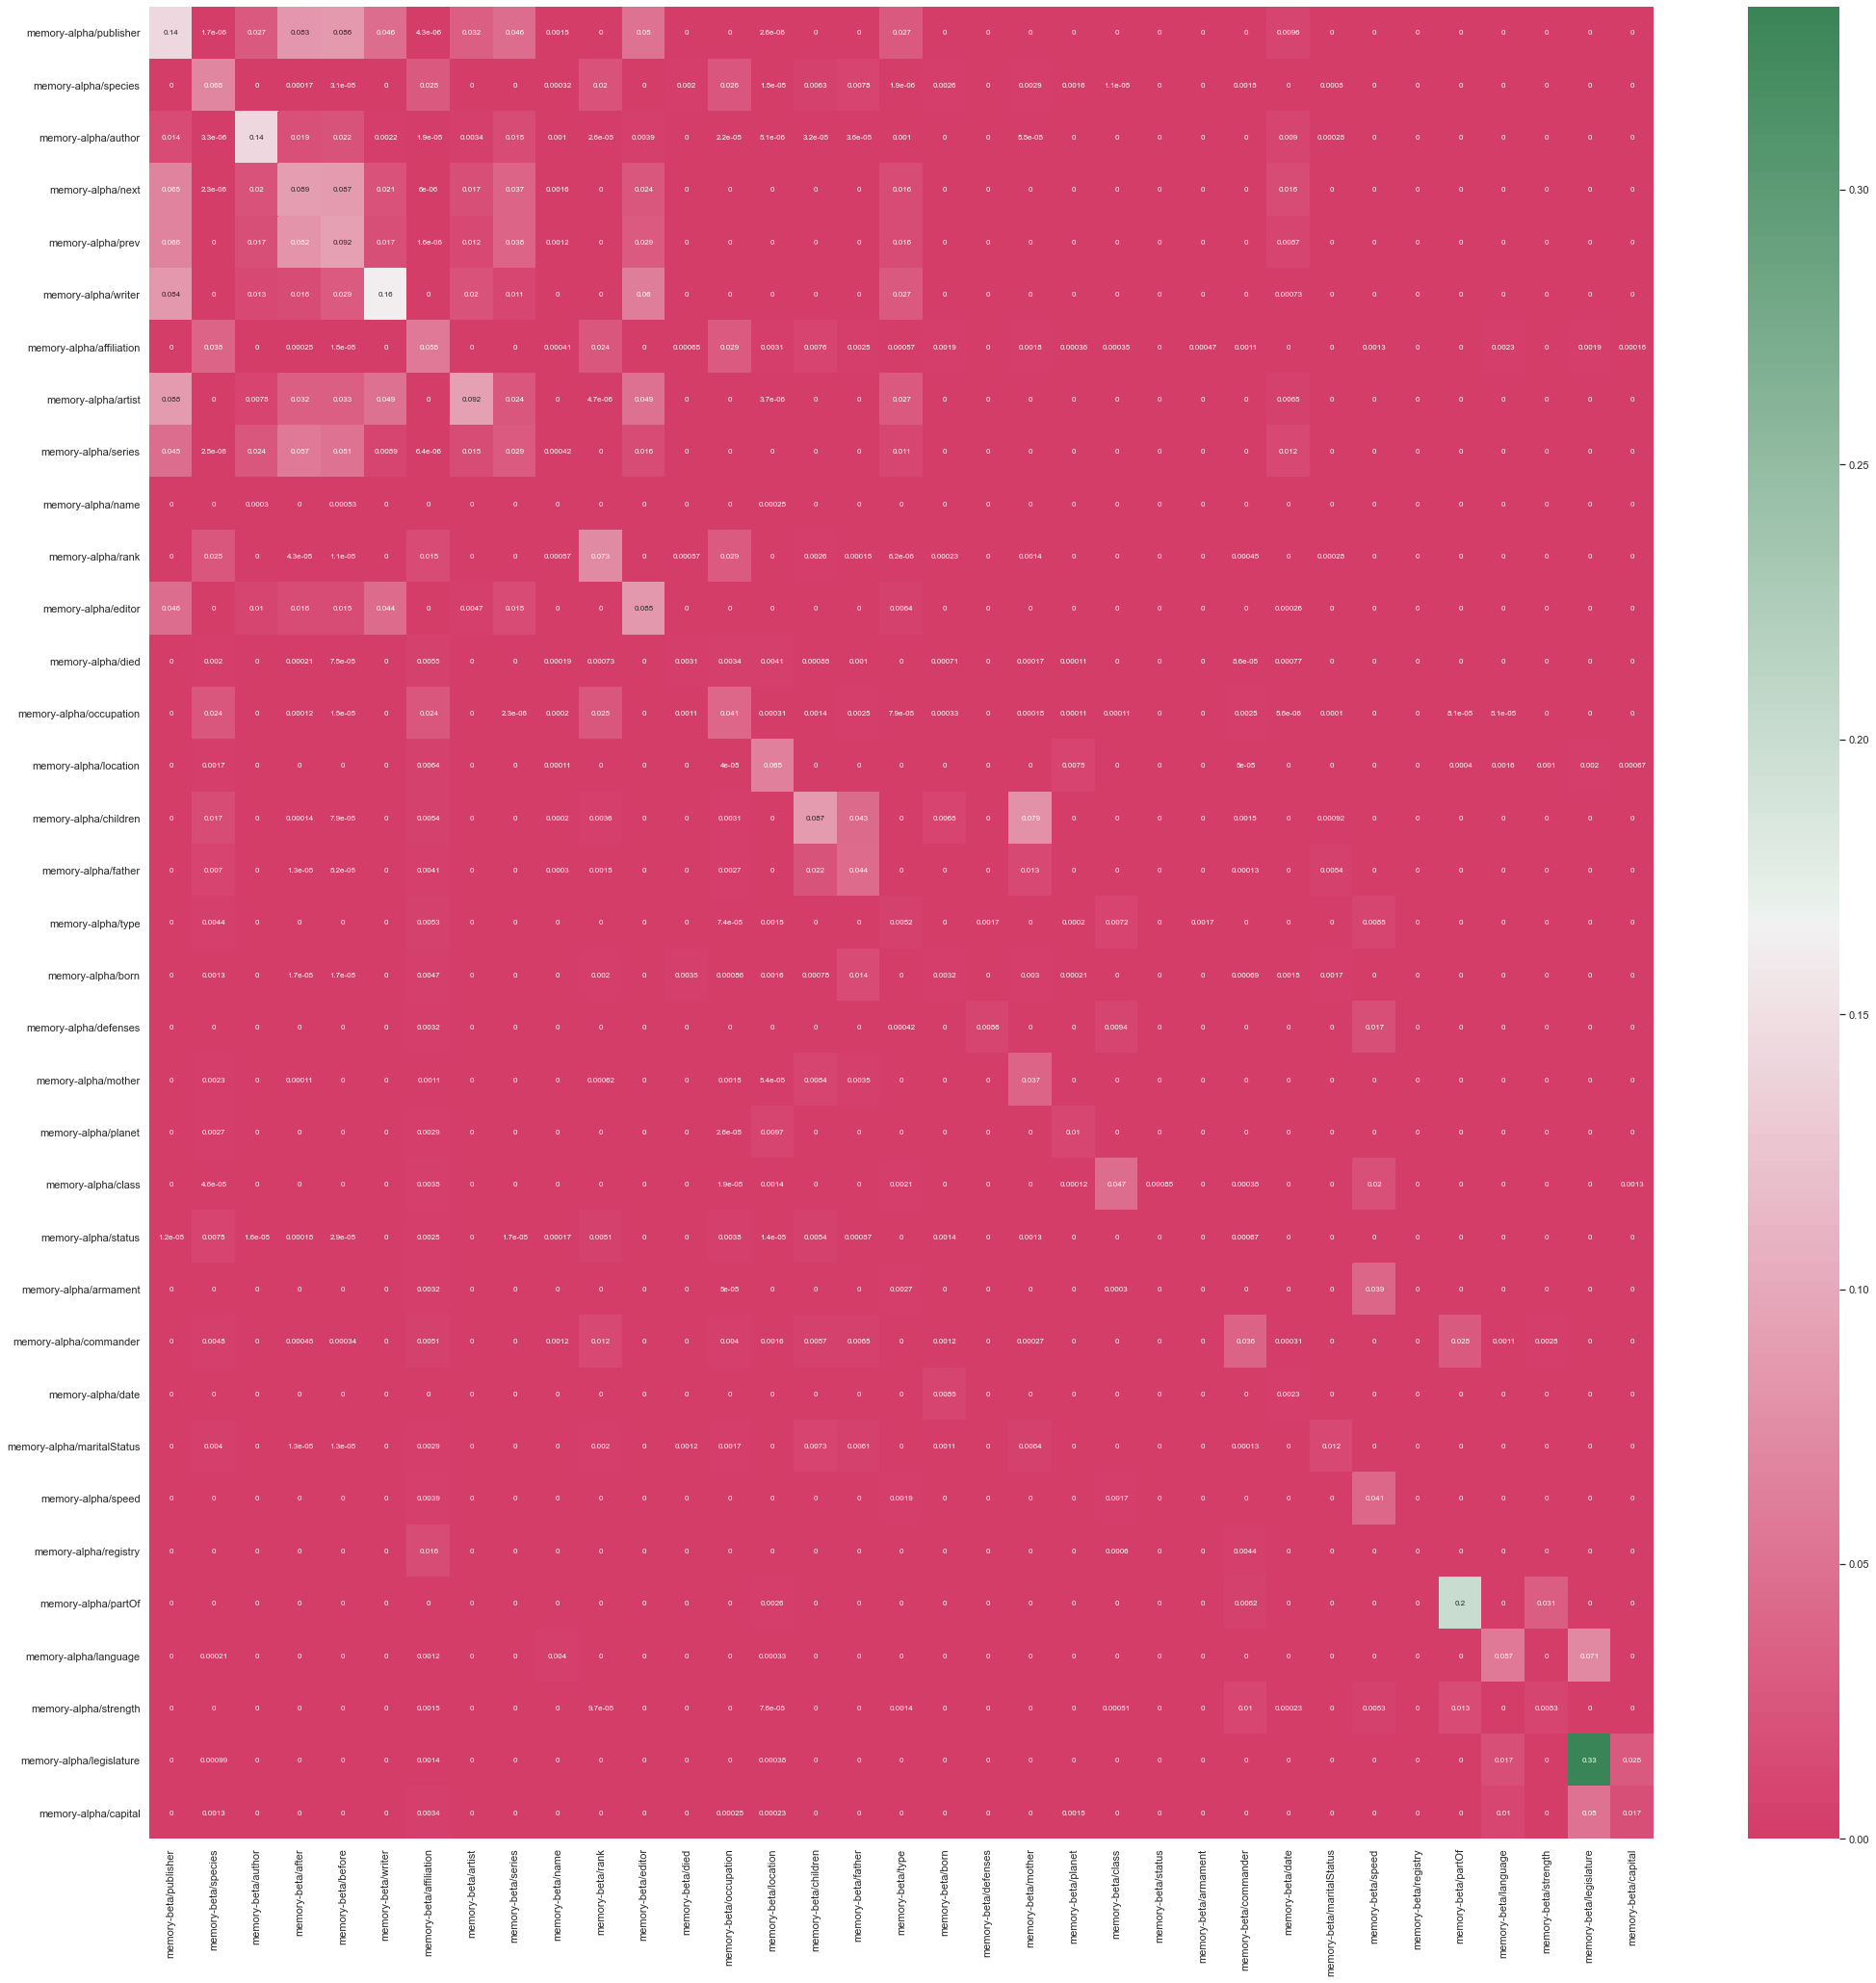

In [190]:
plot_heatmap()

auroc:0.8961464585834333


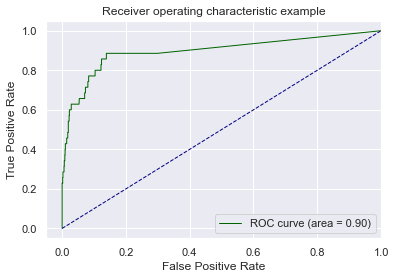

In [193]:
plot_roc()